In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'gs_stitching_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

In [2]:
import scipy.stats as stats

In [2]:
def compare_lists(l1, l2):
    count = 0
    for i1, i2 in zip(l1, l2):
        if i1 != i2:
            count +=1
    return count

In [3]:
def calculate_absolute_mean_diff(a1, a2):
    """calculate the absolute mean difference of elements in 2 equal length arrays"""
    diff = np.array(a1) - np.array(a2)
    diff_abs = np.absolute(diff)
    mean_diff = diff_abs.mean()
    return mean_diff

In [4]:
def get_count_dict(l):
    d = {}
    for i in l:
        d[i] = d.get(i, 0) +1
    return d

In [79]:
def compare_sites(ind1, ind2, cns_t, samples,samples_nmode1, samples_nmode2, cnmode1, cnmode2, samples_lq1, samples_lq2, subtract_lq = True):
    """ calculate the pearson corr of sites in the intersection, calculate the number of differences among non-mode samples """
    data = []

      
    ids = [ind1, ind2]
    ids_mod = ["_".join(i.split('_')[:-1]) for i in ids]
    
    
    cns_1 = cns_t[ind1].to_dict()
    cns_2 = cns_t[ind2].to_dict()
    
        # exclude LQ samps
        
    if subtract_lq:
        samples_to_compare = set(samples_nmode1 + samples_nmode2)
        samples_to_exclude = set(samples_lq1 + samples_lq2)
    
        samples_to_compare_nmode = list(samples_to_compare.difference(samples_to_exclude))
        samples_to_compare_corr = list(set(samples).difference(samples_to_exclude))
#         samples_to_compare_corr = samples
    
        
    
    else: 
        samples_to_compare_corr = samples
        samples_nmode1 = [i for i in samples if cns_1[i] != cnmode1]
        samples_nmode2 = [i for i in samples if cns_2[i] != cnmode2]
        samples_to_compare_nmode = set(samples_nmode1 + samples_nmode2)
        samples_to_exclude = []
    
    cns_nmode_1 = [int(cns_1[i]) for i in samples_to_compare_nmode]
    cns_nmode_2 = [int(cns_2[i]) for i in samples_to_compare_nmode]


    cns_corr_1 = [int(cns_1[i]) for i in samples_to_compare_corr]
    cns_corr_2 = [int(cns_2[i]) for i in samples_to_compare_corr]
    
    allele_dist1 = get_count_dict(cns_corr_1)
    allele_dist2 = get_count_dict(cns_corr_2)
    
    
    
    corr_coef = stats.pearsonr(cns_corr_1, cns_corr_2)[0]
        
        
        
        
    nsamp = len(samples_to_compare_nmode)
    nsamp_pass = len(samples_to_compare_corr)

    num_diff = compare_lists(cns_nmode_1, cns_nmode_2)
    alleles = set(cns_corr_1 + cns_corr_2)
    
    alleles1 = set(cns_corr_1)
    num_alleles1 = len(alleles1)
    alleles2 = set(cns_corr_2)
    num_alleles2 = len(alleles2)

    mean_diff_all = calculate_absolute_mean_diff(cns_corr_1, cns_corr_2)
    mean_diff_nmode = calculate_absolute_mean_diff(cns_nmode_1, cns_nmode_2)
    
    exact_match = (cns_corr_1 == cns_corr_2)

    
    try:
        perc_diff = num_diff/nsamp
    except:
        print nsamp, 'nsamp is zero'
        perc_diff = 0

    out = [ind1, ind2, corr_coef, num_diff, nsamp, 
           perc_diff, samples_to_compare_nmode, samples_to_compare_corr, 
           list(samples_to_exclude), nsamp_pass, exact_match, mean_diff_all, mean_diff_nmode, 
           alleles1, alleles2, num_alleles1, num_alleles2, allele_dist1, allele_dist2]

    return out

In [70]:
def prep_info(df):
    df = df.copy()
    df = df.sort_values(['Chr', 'Start', "End"])
    df = df[df.cnv_class!='Non_Bi']
    return df

def prep_cns(df, info):
    df = df.copy()
    df = df.reindex(info.index)
    return df 

def split_id_to_coord(ID):
    spl = ID.split('_')
    chrom = spl[1]
    start = int(spl[2])
    end = int(spl[3])
    return chrom, start, end

def compute_dist(id1, id2):
    chrom1, start1, end1 = split_id_to_coord(id1)
    chrom2, start2, end2 = split_id_to_coord(id2)
    dist = start2 - end1
    return dist
    

def collect_data_adjacent_sites(info, cns_t, subtract_lq=True):
    
    data = []

    for chrom, df in info.groupby('Chr'):
        inds = df.index.tolist()
        diff_mode_uuids = info.diff_mode_uuids.to_dict()
        mode_cn_all = info.cn_mode.to_dict()
        lq_uuids = info.lq_samps.to_dict()
        cnv_classes = info.cnv_class.to_dict()


        if chrom not in ['X', 'Y']:
            max_range = len(inds)-1 
            for i in range(0, max_range):
                if i < max_range:

                    ind1 = inds[i]
                    ind2 = inds[i+1]
                    pair_ind = '-'.join([ind1, ind2])

                    distance_between = compute_dist(ind1, ind2)
                    if distance_between < 0:
                        absolute_dist = 0
                    else:
                        absolute_dist = distance_between

                    cnv_class1 = cnv_classes[ind1]
                    cnv_class2 = cnv_classes[ind2]

                    diff_uuids1 = diff_mode_uuids[ind1]
                    diff_uuids2 = diff_mode_uuids[ind2]
                    mode_cn1 = mode_cn_all[ind1]
                    mode_cn2 = mode_cn_all[ind2]
                    lq_uuids1 = lq_uuids[ind1]
                    lq_uuids2 = lq_uuids[ind2]
                    pair = [ind1,ind2]
                    
                    num_diff1 = len(diff_uuids1)
                    num_diff2 = len(diff_uuids2)

                    comp = compare_sites(ind1, ind2, cns_t, samples_discovery, 
                                         diff_uuids1, diff_uuids2, mode_cn1, mode_cn2, 
                                         lq_uuids1, lq_uuids2, subtract_lq=subtract_lq)

                    comp = comp + [pair, mode_cn1, mode_cn2, cnv_class1, cnv_class2, distance_between, 
                                   absolute_dist, pair_ind, num_diff1, num_diff2, diff_uuids1, diff_uuids2]
                    data.append(comp)

    df = pd.DataFrame(data, columns=['ID1', 'ID2', 'corr_coef',
                                     'num_diff', 'num_non_mode', 'percent_non_mode_diff', 
                                     'samps_to_compare_nmode', 'samps_to_compare_corr',
                                     'samps_to_exclude', 'num_pass', 'exact_cn_match', 
                                     'mean_cn_diff_all', 'mean_cn_diff_nmode','alleles1', 'alleles2', 
                                     'num_alleles1', 'num_alleles2','allele_dist1', 'allele_dist2','pair', 
                                     'mode_cn1', 'mode_cn2', 'cnv_class1', 'cnv_class2', 
                                     'distance_between', 'distance_between_mod', 'cat_pair', 
                                     'num_diff1', 'num_diff2', 'diff_uuids1', 'diff_uuids2'])
    
    df.index = df.cat_pair
    return df

In [68]:
def collect_data_cluster_sites(info, cns_t, samples):
    
    data = []
    diff_mode_uuids = info.diff_mode_uuids.to_dict()
    mode_cn_all = info.cn_mode.to_dict()
    lq_uuids = info.lq_samps.to_dict()
    cnv_classes = info.cnv_class.to_dict()    

    for stitch_site, df in info.groupby('stitched_cnv_site_ID_mod'):
        inds = df.index.tolist()
#         stitch_site = stitch_site + '_Stitched'
        to_compare_to = [i for i in inds if i != stitch_site]
        if len(to_compare_to) == 0:
            print inds
        
        for x in to_compare_to:
            ind1 = stitch_site
            ind2 = x
            pair_ind = '-'.join([ind1, ind2])
            distance_between = compute_dist(ind1, ind2)
            
            if distance_between < 0:
                absolute_dist = 0
            else:
                absolute_dist = distance_between
            
            
            
            cnv_class1 = cnv_classes[ind1]
            cnv_class2 = cnv_classes[ind2]

            diff_uuids1 = diff_mode_uuids[ind1]
            diff_uuids2 = diff_mode_uuids[ind2]
            num_diff1 = len(diff_uuids1)
            num_diff2 = len(diff_uuids2)
            
            mode_cn1 = mode_cn_all[ind1]
            mode_cn2 = mode_cn_all[ind2]
            lq_uuids1 = lq_uuids[ind1]
            lq_uuids2 = lq_uuids[ind2]
            pair = [ind1,ind2]
            
            comp = compare_sites(ind1, ind2, cns_t, samples, 
                                         diff_uuids1, diff_uuids2, mode_cn1, mode_cn2, 
                                         lq_uuids1, lq_uuids2)

            comp = comp + [pair, mode_cn1, mode_cn2, cnv_class1, cnv_class2, distance_between, 
                           absolute_dist, pair_ind, stitch_site, num_diff1, num_diff2, to_compare_to, 
                           diff_uuids1, diff_uuids2]
            data.append(comp)

    
    
    df = pd.DataFrame(data, columns=['ID1', 'ID2', 'corr_coef',
                                     'num_diff', 'num_non_mode', 'percent_non_mode_diff', 
                                     'samps_to_compare_nmode', 'samps_to_compare_corr',
                                     'samps_to_exclude', 'num_pass', 'exact_cn_match', 
                                     'mean_cn_diff_all', 'mean_cn_diff_nmode','alleles1', 'alleles2', 
                                     'num_alleles1', 'num_alleles2','allele_dist1', 'allele_dist2', 'pair', 
                                     'mode_cn1', 'mode_cn2', 'cnv_class1', 'cnv_class2', 
                                     'distance_between', 'distance_between_mod', 'cat_pair', 
                                     'stitch_site', 'num_diff1', 'num_diff2', 'to_compare_to', 
                                     'diff_uuids1', 'diff_uuids2'])
    
    df.index = df.cat_pair
    return df

In [69]:
def prep_stitch_info(df):
    df = df.copy()
    df = df[df.stitch_b==True]
    df['cat_pair'] = df.cnv1 + '-' + df.cnv2
    df.index =df.cat_pair
    df['chrom'] = df.cnv1.apply(lambda x: x.split('_')[1])
    df = df[~df.chrom.isin(['X', 'Y'])]
    return df

def prep_adj_sites_info(df, stitch_site_pairs_info):
    df = df.copy()
    
    
    inds = stitch_site_pairs_info[stitch_site_pairs_info.status_stitch == True].cat_pair.tolist()
    df['stitched'] = False
    df.loc[inds, 'stitched']= True

    bins = [-1000000000000, 0, 5000, 10000, 50000, 100000000000]
    labels = ['overlap-0bp', '0bp-5kb', '5kb-10kb', '10kb-50kb','50b+']
    
    
    df['length_bins'] = pd.cut(df.distance_between, bins=bins, labels = labels) 
    df['length_bins_plot'] = df.length_bins.astype(str)
    return df
    

def annotate_passing(df, thresh):
    df = df.copy()
    inds = df[(df.corr_coef > 0.9) & (df.percent_non_mode_diff <= 0.2) & (df.mean_cn_diff_all < 0.5) &
              (df.mean_cn_diff_nmode < 0.5) & (df.distance_between_mod < thresh)].index.tolist()
    

    new_size = df.shape[0]
    
    
    df['passing_criteria'] = False
    df.loc[inds, 'passing_criteria'] = True
    return df
    

def prep_adj_sites_plot(adj_sites_prestich, thresh = 5000):  
    adj_sites_prestich = adj_sites_prestich.copy()
    adj_sites_prestich['matching_mode'] = (adj_sites_prestich.mode_cn1 == adj_sites_prestich.mode_cn2)
#     adj_sites_plot = adj_sites_prestich[(adj_sites_prestich.matching_mode == True) & 
#                                     (adj_sites_prestich.num_alleles1 > 1) & 
#                                         (adj_sites_prestich.num_alleles2 > 1)].copy()
    adj_sites_prestich['log_dist'] = np.log10(adj_sites_prestich.distance_between_mod + 1)
    adj_sites_prestich = adj_sites_prestich.pipe(annotate_passing, thresh)
    return adj_sites_prestich

    

# Data import sites before stitching (after with duplicates marked)


In [108]:
out_dir = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined'

In [14]:
info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/gs_info_filt_rmdup.pkl').pipe(prep_info)

In [18]:
cns = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/cns_all.pkl').pipe(prep_cns, info)
cns.drop('old_index', axis =1, inplace=True)

In [19]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

samples_discovery = sample_info[sample_info.CELL_TYPE != 'iPSC'].WGS_ID.tolist()

cns_t = cns.T.copy()
cns_t = cns_t.loc[samples_discovery]

In [80]:
adj_sites_prestich = collect_data_adjacent_sites(info, cns_t, subtract_lq=True)

adj_sites_plot_lq_correct = adj_sites_prestich.pipe(prep_adj_sites_plot, thresh=30000)

passing_lq_correct = adj_sites_plot_lq_correct[adj_sites_plot_lq_correct.passing_criteria == True].index.tolist()

In [109]:
CM.save_dataframe('adjacent_sites_info_lq_correct', adj_sites_plot_lq_correct, out_dir)

adjacent_sites_info_lq_correct = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/adjacent_sites_info_lq_correct.pkl')
adjacent_sites_info_lq_correct = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/adjacent_sites_info_lq_correct.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_pickled_nb_variables.py


# Test Corr against Constituent Breakpoints

# Distribution of percent non-mode diff

# Correlation versus distance of adjacent sites

In [72]:
def plot_2d_hist_corr_logdist(adj_sites_plot):
    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(1,1, figsize = (8,8))
        ax1 = ax

        h = ax1.hist2d(adj_sites_plot.log_dist, adj_sites_plot.corr_coef, cmap=plt.get_cmap('viridis'), bins=30, norm = mpl.colors.LogNorm())

    #     make_plots_square(ax1)
        p =  ax1.get_position()
        rect = [p.x1+0.02, p.y0, 0.05, p.height]
        cax1 = fig.add_subplot(111)
        cax1.set_position(rect)

        fig.colorbar(h[3], cax=cax1, orientation='vertical')

        for a in [ax1]:
              a.set(xlabel='Log10 Distance Between Adjacent CNVs', ylabel='Correlation Coefficient ({})'.format( r'$\rho$'))

        xticks_desired = [1, 100, 1000, 10000, 50000, 100000, 500000, 10000000]
        xticks = [np.log10(i) for i in xticks_desired]
        xtick_label = ['0bp/overlap', '100bp', '1kb', '10kb', '50kb', '100kb', '500kb', '1MB']



        yticks_desired = [1, 10, 100, 1000]
        yticks = [np.log10(i) for i in yticks_desired]
    #     ytick_label = ['0bp/overlap', '100bp', '1kb', '10kb', '50kb', '100kb', '500kb', '1MB']

        ax1.set_xticks(xticks)
        ax1.set_xticklabels(xtick_label, rotation = 90)

        ticks = cax1.get_yticklabels()
        count = 0
        ticklabels = []
        for t in ticks:
            s = t.get_text()
            if s == '':
                ticklabels.append(s)
            else:
                ticklabels.append(yticks_desired[count])
                count +=1
        cax1.set_yticklabels(ticklabels)


    #     cax1.set_yticks(yticks_desired)
    #     cax1.set_yticklabels(yticks_desired)
        print cax1.get_ylim()
    #     cax1.set_yticklabels([10,20, 30,40,'50+'])
    #     cax2.set_yticklabels([10,20, 30,40,'50+']) 
    #     cax2.set_ylabel('No. Pairs of Sites')
        cax1.set_ylabel('No. Pairs of Sites')

In [77]:
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14

(0.0, 1.0)


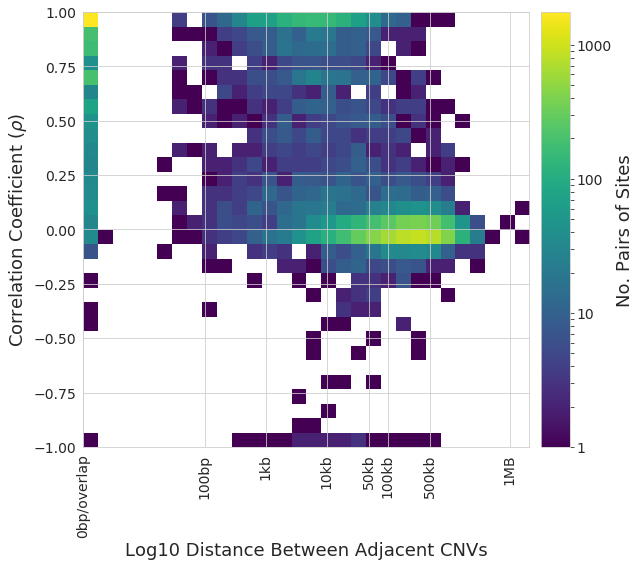

In [81]:
plot_2d_hist_corr_logdist(adj_sites_plot_lq_correct[adj_sites_plot_lq_correct.corr_coef.isnull() == False])

# Number/Percent passing threshold versus distance threshold

In [82]:
def percent_and_num_pass_dist_thresh(df, dist = 5000):
    df = df.copy()
    original_size = df.shape[0] 
    df = df[df.distance_between_mod < dist]
    size_below_dist = df.shape[0]
    
    df = df[(df.corr_coef > 0.9) & (df.percent_non_mode_diff <= 0.2) & (df.mean_cn_diff_all < 0.5) & (df.mean_cn_diff_nmode < 0.5)]
    new_size = df.shape[0]
    
    percent_of_sites_below_dist = (size_below_dist/original_size) * 100
    percent_passing = (new_size/size_below_dist) * 100
    
    
    return original_size, size_below_dist, new_size, percent_of_sites_below_dist, percent_passing

In [83]:
def gather_threshold_info(adj_sites):
    thresholds = [1, 5000, 10000, 20000, 30000, 40000, 100000, 500000]
    data = []
    for thresh in thresholds:
        original_size, size_below_dist, new_size, percent_of_sites_below_dist, percent_passing= adj_sites.pipe(percent_and_num_pass_dist_thresh, dist=thresh)

        data.append([thresh, original_size, size_below_dist, new_size, 
                     percent_of_sites_below_dist, percent_passing])

    df = pd.DataFrame(data, columns=['threshold', 'total_pairs', 'num_pairs_below_dist', 'num_pairs_passing', 'percent_below_dist', 'percent_passing'])

    df['log_threshold'] = np.log10(df.threshold)
    return df

In [84]:
def plot_perc_passing_vs_num_passing(df):
    

    with sns.axes_style('whitegrid'):
        fig, ax = plt.subplots(1,1, figsize = (8,5))

        ax.scatter(df.num_pairs_passing, df.percent_passing, s= 60)
    #     ax.set_xticks(df.tolist())
    #     ax.set_xticklabels(df.threshold.tolist(), rotation = 90)

        ax.set(xlabel='No. pairs of sites passing stitching requirements', ylabel='Percent Passing Stiching Requirements')

        threshes = df.threshold.tolist()
        Y_coord = df.percent_passing.tolist()
        X_coord = df.num_pairs_passing.tolist()
        threshold_text = ['overlap', '5kb', '10kb', '20kb', '30kb','40kb', '100kb', '500kb']

        colors = ['black', 'black', 'black', 'black', 'green', 'black', 'black', 'black']
        fontweights = ['regular', 'regular', 'regular', 'regular', 'extra bold', 'regular', 'regular', 'regular']
        for t, y, text, x, c, w in zip(threshes, Y_coord, threshold_text, X_coord, colors, fontweights):

            ax.annotate(text, xy=(x+20, y), fontsize=12, horizontalalignment = 'left', verticalalignment='center', color=c, fontweight= w)
        ax.set_ylim(0,75)
        return ax


In [85]:
threshold_comp_lq_correct = gather_threshold_info(adj_sites_plot_lq_correct)

In [86]:
thresholds = [1, 5000, 10000, 20000, 30000, 40000, 100000, 500000]
threshold_text = ['overlap', '5kb', '10kb', '20kb', '30kb','40kb', '100kb', '500kb']

In [ ]:
# ax = plot_perc_passing_vs_num_passing(threshold_comp_lq_correct)

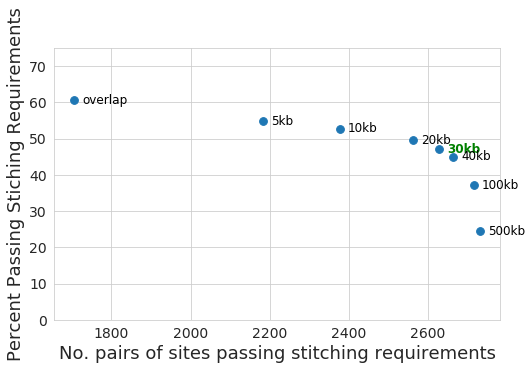

In [87]:
ax = plot_perc_passing_vs_num_passing(threshold_comp_lq_correct)

In [111]:
CM.save_dataframe('threshold_comp_stitch_lq_correct', threshold_comp_lq_correct, out_dir)

threshold_comp_stitch_lq_correct = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/threshold_comp_stitch_lq_correct.pkl')
threshold_comp_stitch_lq_correct = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/threshold_comp_stitch_lq_correct.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_pickled_nb_variables.py


# Data import ALL sites including stitching

In [88]:
info_all =  pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/gs_info_stitch_annot_qual.pkl')

info_all.stitched_cnv_site_ID_mod = info_all.stitched_cnv_site_ID_mod.fillna(False)

info_all.stitch_breakpoint.value_counts()

cns_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/cns_all_with_stitch.pkl')

sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

samples_discovery = sample_info[sample_info.CELL_TYPE != 'iPSC'].WGS_ID.tolist()
cns_t = cns_all.T.copy()
cns_t = cns_t.loc[samples_discovery]

# Collect data comparing newly genotyped stitch breakpoints to the constituent breakpoints, look at the correlation of copy numbers called on the new site. 
## If stitch breakpoints no longer correlate with their constituent sites, there is variability in coverage between the breakpoints that were stitched.  We will not use these uncorrelated breakpoints and will "unstitch" them 

In [89]:
info_stitch = info_all[(info_all.stitched_cnv_site_ID != False)].copy()

stitching_cols = 'stitch_cluster_ID	stitch_cluster	stitch_breakpoint	stitch_constituent	stitched_cnv_site_ID stitch_site_already_gt stitched_cnv_site_ID_mod'.split()

In [90]:
cluster_sites = collect_data_cluster_sites(info_stitch, cns_t, samples_discovery)

In [91]:
inds = info_all[(info_all.stitch_breakpoint==True) & (info_all.stitch_site_already_gt == True)].index.tolist()

cluster_filt = cluster_sites[~cluster_sites.ID1.isin(inds)]
cluster_agt = cluster_sites[cluster_sites.ID1.isin(inds)]

In [92]:
clust_newbp_plot = cluster_filt.groupby('stitch_site').corr_coef.mean().to_frame()

clust_agt_plot= cluster_agt.groupby('stitch_site').corr_coef.mean().to_frame()

In [93]:
out_dir = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined'

In [106]:
# this data will be used to "unstitch" some sites

In [24]:
CM.save_dataframe('stitch_sites_corr_with_const', cluster_sites, out_dir)

stitch_sites_corr_with_const = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/stitch_sites_corr_with_const.pkl')
stitch_sites_corr_with_const = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/stitch_sites_corr_with_const.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_pickled_nb_variables.py


In [107]:
CM.save_dataframe('new_bp_mean_corr_with_const', clust_newbp_plot, out_dir)

new_bp_mean_corr_with_const = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/new_bp_mean_corr_with_const.pkl')
new_bp_mean_corr_with_const = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/new_bp_mean_corr_with_const.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/load_pickled_nb_variables.py


In [99]:
new_bp_fail = clust_newbp_plot[clust_newbp_plot.corr_coef < 0.9].shape[0]

new_bp_pass = clust_newbp_plot[clust_newbp_plot.corr_coef > 0.9].shape[0]

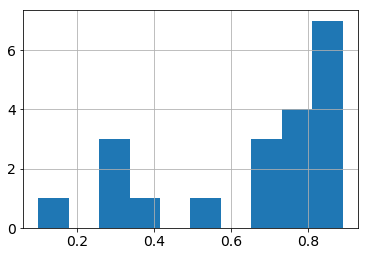

In [98]:
clust_newbp_plot[clust_newbp_plot.corr_coef < 0.9].corr_coef.hist()

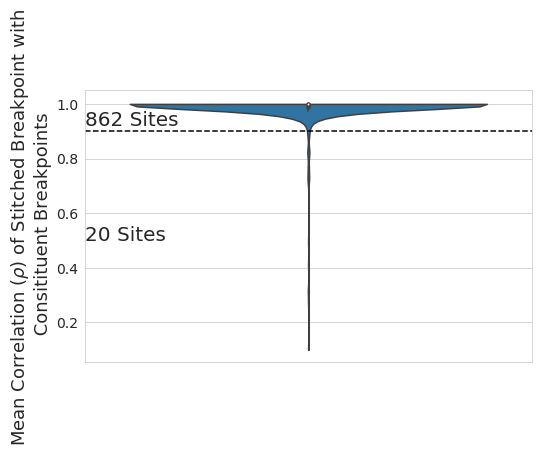

In [105]:
with sns.axes_style('whitegrid'):
    
    fig, ax = plt.subplots(1,1, figsize = (8,5))
    sns.violinplot(y = clust_newbp_plot.corr_coef, cut= 0)
    ax.set_ylabel('Mean Correlation ({}) of Stitched Breakpoint with \n Consitituent Breakpoints'.format( r'$\rho$'))
    ax.set_xlabel('')
    ax.axhline(y=0.9, linestyle='--', c='black')
#     ax.set_xticklabels('')
    ax.text(-.5, 0.5, '{} Sites'.format(new_bp_fail), fontsize =20)
    
    ax.text(-.5, 0.92, '{} Sites'.format(new_bp_pass), fontsize =20)

The majority of stitch breakpoints correlate well with their constituents, indicating that the stitching operation was likely to be appropriate. 